<a href="https://colab.research.google.com/github/Molten-Ice/Deep-Learning/blob/dev/VesuviusChallenge/VesuviusChallenge_nb1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VesuviusChallenge - Deciphering Ancient Papyrus Scrolls

## Download data

In [1]:
### Download data from kaggle, and store a segment of it in google drive

# import json
# import zipfile
# kaggle_apikey = {"username":"jamesdavey","key":"a8975caa44cfa08d6f2164f2d5977b6e"}

# if not os.path.exists('/root/.kaggle'): os.mkdir('/root/.kaggle')
# with open('/root/.kaggle/kaggle.json', 'w') as f:
#     json.dump(kaggle_apikey, f)

# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle competitions download -c 'vesuvius-challenge-ink-detection' --force
# # #1% 131M/20.6G [00:06<17:23, 21.1MB/s]

# with zipfile.ZipFile("/content/vesuvius-challenge-ink-detection.zip","r") as zip_ref:
#     zip_ref.extractall("kaggledata")

# !zip -r -j /content/ink1.zip /content/content/kaggledata/train/1

# # upload zip to google drive
# from google.colab import drive
# drive.mount('/content/gdrive')
# !cp /content/ink1.zip /content/gdrive/MyDrive/AIData/vesuvius1.zip

In [2]:
## Retrieve data(zip) from google drive
from google.colab import drive
drive.mount('/content/gdrive')
!cp /content/gdrive/MyDrive/AIData/vesuvius1.zip /content/vesuvius1.zip 

Mounted at /content/gdrive


In [8]:
import zipfile
with zipfile.ZipFile("vesuvius1.zip","r") as zip_ref:
    zip_ref.extractall("train_data")
drive.flush_and_unmount()

## Imports

In [10]:
import torch
import torch.nn as nn
import numpy as np
import PIL
# import torch.utils.data as data
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
# from ipywidgets import interact, fixed
from pathlib import Path
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"on device: {device}")

on device: cuda


## Understanding the data

In [37]:
root_filepath = '/content/train_data/'

all_files = sorted(os.listdir(root_filepath))
# ['inklabels.png', 'inklabels_rle.csv', 'ir.png', 'mask.png']
tif_filenames = all_files[:-4]
print(len(tif_filenames))

65


In [35]:
import pandas as pd
df = pd.read_csv(root_filepath+'inklabels_rle.csv')
print(len(df.Predicted[0]))
df.head()

348148


,Id,Predicted
0,1,606211 19 612538 26 618867 39 625196 44 631525...


img_original shape: (8181, 6330)
img_ink_labels shape: (8181, 6330)
img_ink_mask shape: (8181, 6330)


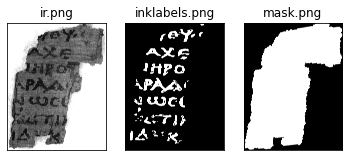

In [36]:
img_original = np.array(PIL.Image.open(root_filepath+'ir.png'))
img_ink_labels = np.array(PIL.Image.open(root_filepath+'inklabels.png'))
img_ink_mask = np.array(PIL.Image.open(root_filepath+'mask.png'))
print(f"img_original shape: {img_original.shape}")
print(f"img_ink_labels shape: {img_ink_labels.shape}")
print(f"img_ink_mask shape: {img_ink_mask.shape}")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.set_title('ir.png')
ax1.imshow(img_original, cmap = 'gray')
ax2.set_title('inklabels.png')
ax2.imshow(img_ink_labels, cmap = 'gray')
ax3.set_title('mask.png')
ax3.imshow(img_ink_mask, cmap = 'gray')
for ax in [ax1, ax2, ax3]:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

[0.0, 0.69755095, 0.8771649, 0.855787]


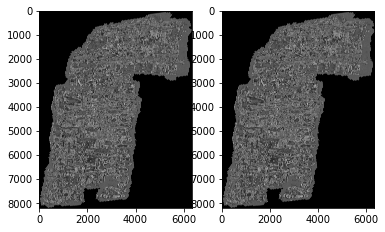

In [38]:
#Each tif file is a layer in the scan
images = []
for path in tif_filenames[:5]:
    images.append(np.array(PIL.Image.open(root_filepath+path), dtype = np.float32)/65535.0)
print([images[0][i].max() for i in range(0, 2000, 500)])

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(images[0], cmap = 'gray')
ax2.imshow(images[1], cmap = 'gray')
plt.show()

## Creating and training model

In [39]:
image_stack = torch.stack([torch.from_numpy(img) for img in images], dim = 0)
print(image_stack.shape)

torch.Size([5, 8181, 6330])
